In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [43]:
# Datasets
from pyspdetection.networks.generators import BarabasiAlbertNetworks, RealNetwork, ErdosReyniNetworks
from pyspdetection.networks.modifiers import RemoveRandomEdges, RemoveRandomNodes
from pyspdetection.networks.base import TemporalNetworks
from pyspdetection.dynamics import LotkaVolterraDynamics, SISDynamics, ThetaDynamics
from pyspdetection.dataset import Dataset

# Models
from pyspdetection.gnn import LotkaPredictor, GNNConfig
from pyspdetection.reconstruction import ReconstructionConfig, CorrelationModel, GrangerCausality

# Dataset

### The graph must be directed

In [4]:
# Erdos
graph_generator = ErdosReyniNetworks(N=100, density=0.1, directed=True)
G = graph_generator()

### Perturbation: Remove nodes

In [5]:
modifier = RemoveRandomEdges(n_edges=20)

### Dymamics

In [32]:
dynamics = LotkaVolterraDynamics(intra_competition=0.1, alpha=0.9)

### Create a dataset

In [33]:
t_perturb = 100
temporal_network = TemporalNetworks.from_modifiers(modifiers=[(t_perturb, modifier)], 
                                                   graph_generator=graph_generator)
dataset = Dataset(temporal_network, dynamics)

T = np.arange(200)
Xtrain = dataset.time_series(T, burn=100)
G0 = temporal_network(0)
G1 = temporal_network(T[-1])
W0 = nx.to_numpy_array(G0)
W1 = nx.to_numpy_array(G1)
dW = W0-W1

Text(0, 0.5, 'Activity')

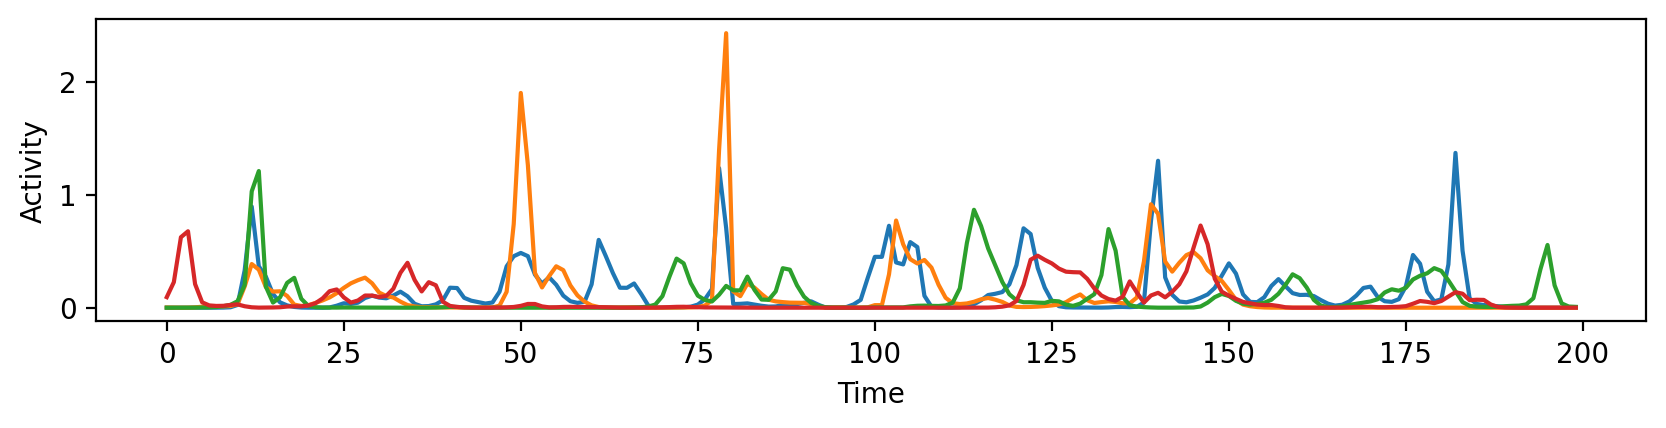

In [40]:
plt.figure(figsize=(10,2), dpi=200)
nodes = [0,5,10, 20]
for node in nodes:
    plt.plot(Xtrain[:, node])
plt.xlabel('Time')
plt.ylabel("Activity")

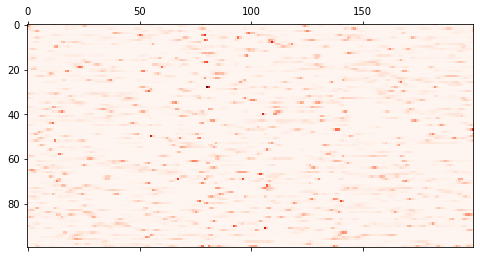

In [41]:
plt.matshow(Xtrain.T, cmap="Reds")

Text(0.5, 1.0, 'Target perturbation')

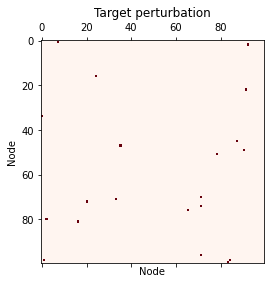

In [42]:
plt.matshow(W0-W1, cmap="Reds")
plt.xlabel("Node")
plt.ylabel("Node")
plt.title('Target perturbation')

# GNN

In [44]:
predictor = LotkaPredictor(config=GNNConfig.LotkaNetV2())

In [45]:
dW_GNN = predictor.predict(Xtrain.T, W0, t_perturb)

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/edwardl/Documents/Personnel/structural-perturbation/pyspdetection/utils/optimizer.py:45: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
100%|██████████| 5000/5000 [00:19<00:00, 253.86it/s]


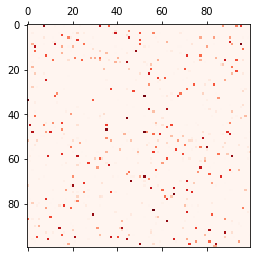

In [46]:
plt.matshow(dW_GNN, cmap="Reds")

# Functional approaches

In [47]:
config = ReconstructionConfig.correlation()
corr_model = CorrelationModel(config)


In [48]:
dW_corr = corr_model.predict(Xtrain.T, W0, t_perturb)

/Users/edwardl/opt/miniconda3/envs/py_spdetection/lib/python3.8/site-packages/netrd/utilities/threshold.py:40: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  warnings.warn(


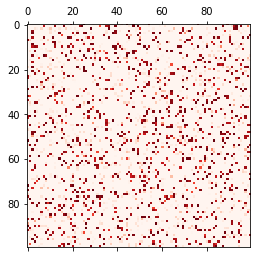

In [49]:
plt.matshow(dW_corr, cmap="Reds")

# Granger

In [50]:
config = ReconstructionConfig.granger()
granger_model = GrangerCausality(config)

In [51]:
dW_granger = corr_model.predict(Xtrain.T, W0, t_perturb)

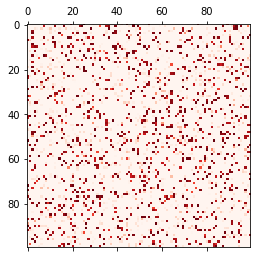

In [52]:
plt.matshow(dW_granger, cmap="Reds")

# Evaluation

In [53]:
from sklearn.metrics import roc_curve, auc

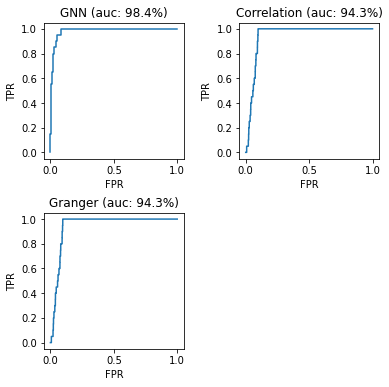

In [54]:
fpr_gnn, tpr_gnn, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_GNN.flatten())
fpr_coor, tpr_coor, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_corr.flatten())
fpr_granger, tpr_granger, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_granger.flatten())


fig, axarr = plt.subplots(2, 2, figsize=(6,6))
k = 0 
for i in range(2):
    for j in range(2):
        ax = axarr[i,j]
        if k==0:
            ax.plot(fpr_gnn, tpr_gnn)
            ax.set_title(f'GNN (auc: {auc(fpr_gnn, tpr_gnn):.1%})')
        elif k==1:
            ax.plot(fpr_coor, tpr_coor)
            ax.set_title(f'Correlation (auc: {auc(fpr_coor, tpr_coor):.1%})')
        elif k==2:
            ax.plot(fpr_granger, tpr_granger)
            ax.set_title(f'Granger (auc: {auc(fpr_granger, tpr_granger):.1%})')
        else:
            ax.axis('off')
        k += 1
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        
plt.subplots_adjust(wspace=0.4, hspace=0.4)

## Precision recall

In [55]:
from sklearn.metrics import precision_recall_curve

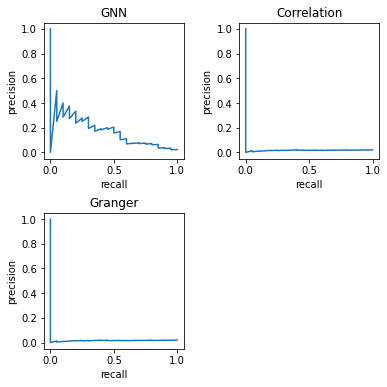

In [56]:
precision_gnn, recall_gnn, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_GNN.flatten())
precision_coor, recall_coor, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_corr.flatten())
precision_granger, recall_granger, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_granger.flatten())


fig, axarr = plt.subplots(2, 2, figsize=(6,6))
k = 0 
for i in range(2):
    for j in range(2):
        ax = axarr[i,j]
        if k==0:
            ax.plot(recall_gnn, precision_gnn)
            ax.set_title('GNN')
        elif k==1:
            ax.plot(recall_coor, precision_coor)
            ax.set_title('Correlation')
        elif k==2:
            ax.plot(recall_granger, precision_granger)
            ax.set_title('Granger')
        else:
            ax.axis('off')
        k += 1
        ax.set_xlabel("recall")
        ax.set_ylabel("precision")
        
plt.subplots_adjust(wspace=0.4, hspace=0.4)